In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit
import scipy.interpolate
import scipy.optimize
import os
import lmfit
from tqdm import tqdm

import fit_functions
import nekhoroshev_tools

In [2]:
fixed_value = 1.8e-11

m_6052 = -97e-15
q_6052 = 6.2e-13
r2_6052 = 3.5e-26

m_6194 = -59e-15
q_6194 = 4.1e-13
r2_6194 = 0.8e-26

m_7221 = -3.4e-15
q_7221 = 2.8e-13
r2_7221 = 0.2e-26

m_7392 = -10e-15
q_7392 = 5.3e-13
r2_7392 = 0.4e-26

In [3]:
with open("colimator-scans-data.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
with open("colimator-scans-details.pkl", "rb") as f:
    details = pickle.load(f)

# Grab some beam data properly

In [5]:
details[6052]["beam1"]["horizontal"]

{'startTime': '2017-08-06 22:40:00',
 'endTime': '2017-08-07 00:50:00',
 'stepsRange': [4, 40],
 'measuredEmittance': 3.5,
 'nominalBeamSizeUM': 280,
 'dataFileName': 'local_data/6052_MD_Scraping_BLM_TCP_C6_L7_B1.csv',
 'movingJaw': 'TCP.C6L7.B1:MEAS_LVDT_LU',
 'nonMovingJaw': 'TCP.C6L7.B1:MEAS_LVDT_RU'}

In [6]:
details[6052]["beam1"]["vertical"]

{'startTime': '2017-08-06 22:40:00',
 'endTime': '2017-08-07 00:50:00',
 'stepsRange': [4, 51],
 'measuredEmittance': 4.0,
 'nominalBeamSizeUM': 200,
 'dataFileName': 'local_data/6052_MD_Scraping_BLM_TCP_D6_L7_B1.csv',
 'movingJaw': 'TCP.D6L7.B1:MEAS_LVDT_LU',
 'nonMovingJaw': 'TCP.D6L7.B1:MEAS_LVDT_RU'}

In [7]:
data[6052]["TCP_IR7_B1H"]["lowres"].keys()

dict_keys(['timestamps', 'TCP.C6L7.B1:MEAS_LVDT_LU', 'LHC.BCTDC.A6R4.B1:BEAM_INTENSITY', 'LHC.BCTDC.A6R4.B2:BEAM_INTENSITY', 'TCP.C6R7.B2:MEAS_LVDT_LU'])

In [8]:
data[6052]["TCP_IR7_B1V"]["lowres"].keys()

dict_keys(['timestamps', 'TCP.D6L7.B1:MEAS_LVDT_LU', 'LHC.BCTDC.A6R4.B1:BEAM_INTENSITY', 'LHC.BCTDC.A6R4.B2:BEAM_INTENSITY', 'TCP.D6R7.B2:MEAS_LVDT_LU'])

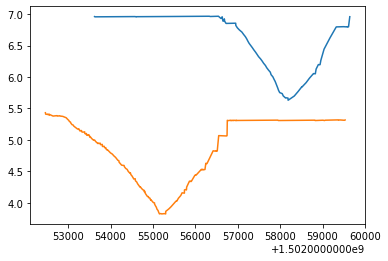

In [9]:
plt.plot(
    data[6052]["TCP_IR7_B1H"]["lowres"]["timestamps"],
    data[6052]["TCP_IR7_B1H"]["lowres"]["TCP.C6L7.B1:MEAS_LVDT_LU"] / 0.28,
)

# plt.plot(
#     data[6052]["TCP_IR7_B1H"]["lowres"]["timestamps"],
#     data[6052]["TCP_IR7_B1H"]["lowres"]["TCP.C6R7.B2:MEAS_LVDT_LU"] / 0.28,
# )

plt.plot(
    data[6052]["TCP_IR7_B1V"]["lowres"]["timestamps"],
    data[6052]["TCP_IR7_B1V"]["lowres"]["TCP.D6L7.B1:MEAS_LVDT_LU"] / 0.20,
)

# plt.plot(
#     data[6052]["TCP_IR7_B1V"]["lowres"]["timestamps"],
#     data[6052]["TCP_IR7_B1V"]["lowres"]["TCP.D6R7.B2:MEAS_LVDT_LU"] / 0.28,
# )


In [85]:
data[6052]["TCP_IR7_B1V"]["hires"].keys()

dict_keys(['BLMTI.06L7.B1E10_TCP.D6L7.B1:LOSS_FAST', 'LHC.BCTDC.A6R4.B1:BEAM_INTENSITY', 'LHC.BCTDC.A6R4.B2:BEAM_INTENSITY', 'BLMTI.06L7.B1E10_TCP.C6L7.B1:LOSS_RS09', 'BLMEI.06L7.B1E10_TCP.A6L7.B1:LOSS_RS09'])

In [86]:
d = data[6052]["TCP_IR7_B1V"]["hires"]["BLMTI.06L7.B1E10_TCP.C6L7.B1:LOSS_RS09"]
d[1][d[1]<=0] = np.nan

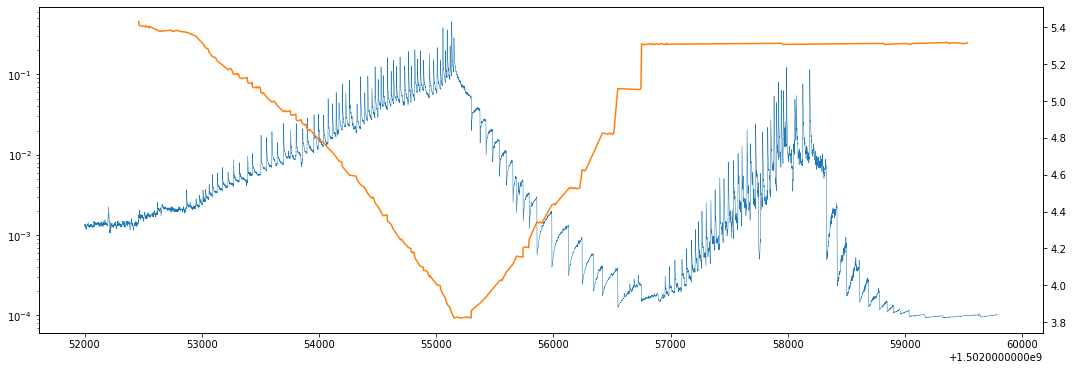

In [88]:
plt.figure(figsize=(18, 6))

plt.plot(d[0], d[1], linewidth=0.5)
plt.yscale("log")

plt.twinx()
plt.plot(
    data[6052]["TCP_IR7_B1V"]["lowres"]["timestamps"],
    data[6052]["TCP_IR7_B1V"]["lowres"]["TCP.D6L7.B1:MEAS_LVDT_LU"] / 0.20,
    c="C1"
)

(1502055000.0, 1502057000.0)

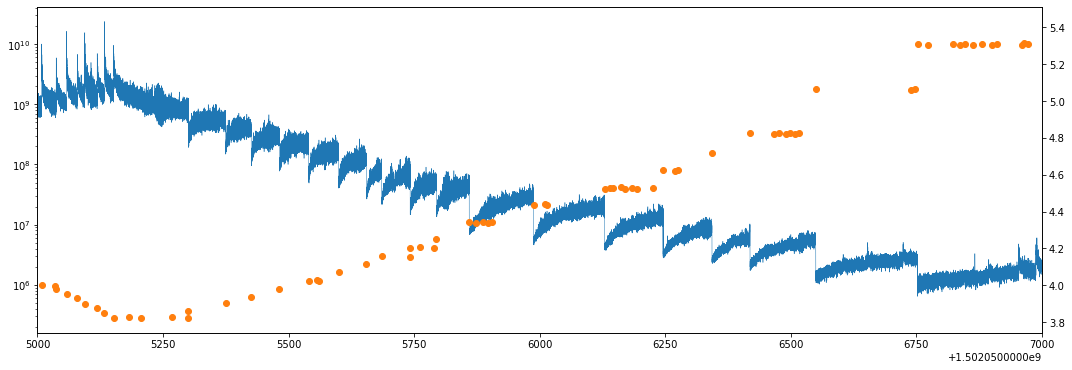

In [13]:
plt.figure(figsize=(18, 6))

plt.plot(d[0], d[1] / fixed_value, linewidth=0.5)
plt.yscale("log")

plt.twinx()
plt.scatter(
    data[6052]["TCP_IR7_B1V"]["lowres"]["timestamps"],
    data[6052]["TCP_IR7_B1V"]["lowres"]["TCP.D6L7.B1:MEAS_LVDT_LU"] / 0.20,
    c="C1"
)

plt.xlim(55000+1.5020e9, 57000+1.5020e9)

In [14]:
func = scipy.interpolate.interp1d(
    data[6052]["TCP_IR7_B1V"]["lowres"]["timestamps"],
    data[6052]["TCP_IR7_B1V"]["lowres"]["TCP.D6L7.B1:MEAS_LVDT_LU"] / 0.20,
    kind="previous", fill_value="extrapolate"
)

(1502055250.0, 1502056750.0)

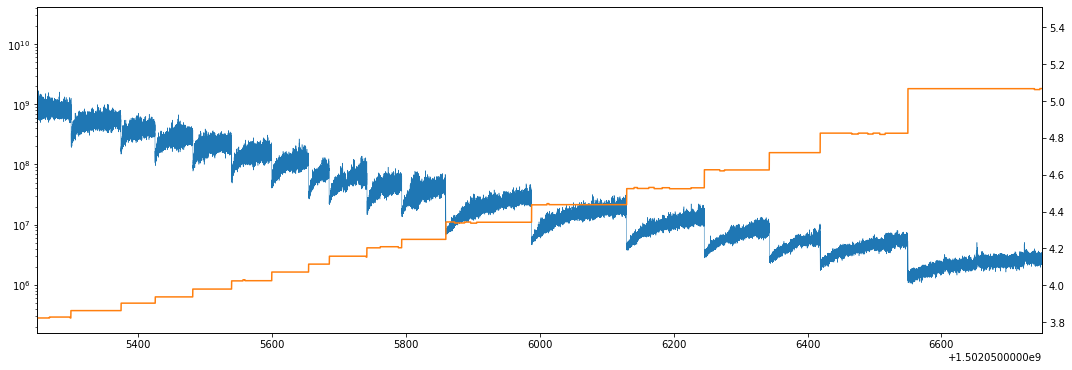

In [15]:
plt.figure(figsize=(18, 6))

plt.plot(d[0], d[1] / fixed_value, linewidth=0.5)
plt.yscale("log")

plt.twinx()
plt.plot(
    d[0],
    func(d[0]),
    c="C1"
)

plt.xlim(55250+1.5020e9, 56750+1.5020e9)

(1502055250.0, 1502056750.0)

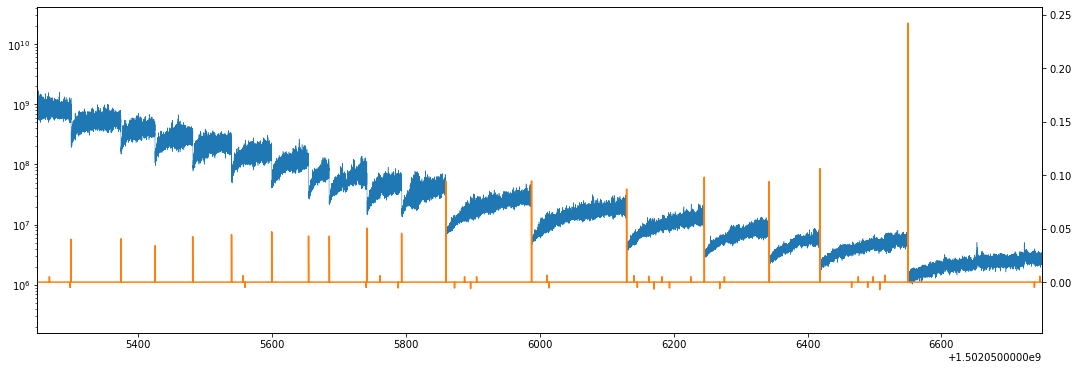

In [16]:
plt.figure(figsize=(18, 6))

plt.plot(d[0], d[1] / fixed_value, linewidth=0.5)
plt.yscale("log")

plt.twinx()
plt.plot(
    d[0][:-1],
    np.diff(func(d[0])),
    c="C1"
)

plt.xlim(55250+1.5020e9, 56750+1.5020e9)

In [17]:
diffs = np.diff(func(d[0]))
idxs = np.where(diffs > 0.01)[0]
vals = d[0][np.where(diffs > 0.01)]

In [18]:
idxs

array([329838, 337335, 342432, 348031, 353829, 359827, 365324, 368424,
       374021, 379219, 385817, 398611, 412807, 424404, 434101, 441697,
       454793, 475086])

(1502055250.0, 1502056750.0)

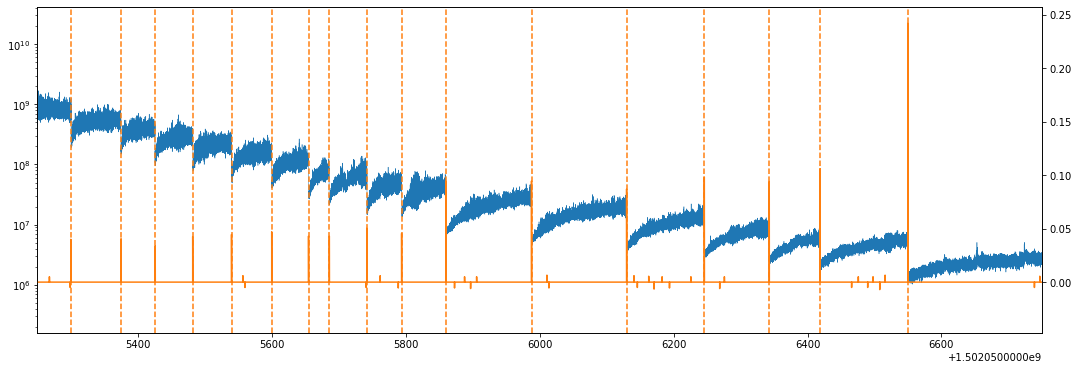

In [19]:
plt.figure(figsize=(18, 6))

plt.plot(d[0], d[1] / fixed_value, linewidth=0.5)
plt.yscale("log")

plt.twinx()
plt.plot(
    d[0][:-1],
    np.diff(func(d[0])),
    c="C1"
)

for v in vals:
    plt.axvline(v, c="C1", linestyle="--")

plt.xlim(55250+1.5020e9, 56750+1.5020e9)

In [20]:
slices = []

for i in range(len(vals) - 1):
    slices.append((
        d[0][idxs[i]: idxs[i+1]],
        d[1][idxs[i]: idxs[i+1]],
        np.mean(func(d[0][idxs[i]+1: idxs[i+1]-1])),
        (idxs[i], idxs[i+1])
    ))

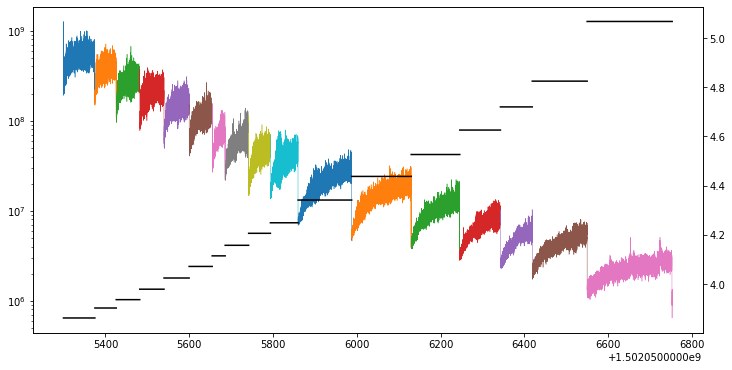

In [21]:
# plt.figure(figsize=(18, 6))
plt.figure(figsize=(12, 6))

for s in slices:
    plt.plot(s[0], s[1] / fixed_value, linewidth=0.5)
plt.yscale("log")

plt.twinx()
for s in slices:
    plt.plot(
        s[0],
        np.ones_like(s[0]) * s[2],
        c="black")

In [22]:
@njit
def moving_average(a: np.ndarray, n=1) -> np.ndarray :
    out = a.copy()
    for i in range(len(a)):
        out[i] = np.nanmean(a[max(0, i-n): min(len(a), i+n+1)])
    return out

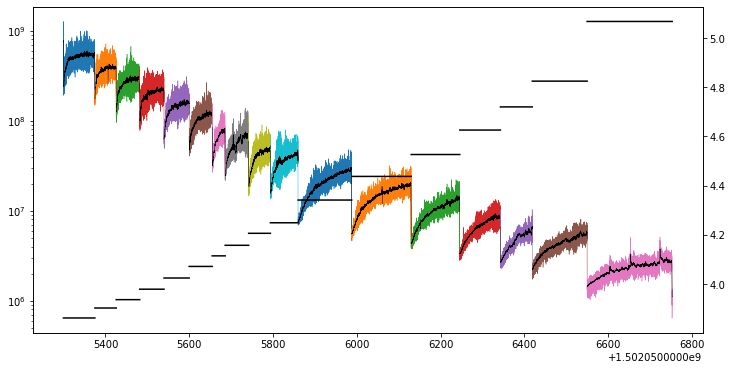

In [23]:
# plt.figure(figsize=(18, 6))
plt.figure(figsize=(12, 6))

for s in slices:
    plt.plot(s[0], s[1] / fixed_value, linewidth=0.5)
    plt.plot(s[0], moving_average(s[1] / fixed_value, n=30), linewidth=0.5, c="black")
plt.yscale("log")

plt.twinx()
for s in slices:
    plt.plot(
        s[0],
        np.ones_like(s[0]) * s[2],
        c="black")

In [24]:
slices = []

for i in range(len(vals) - 1):
    slices.append((
        d[0][idxs[i]: idxs[i+1]],
        d[1][idxs[i]: idxs[i+1]],
        np.mean(func(d[0][idxs[i]+1: idxs[i+1]-1])),
        (idxs[i], idxs[i+1])
    ))

In [25]:
def reset_indexes(slices, slice_val=100):
    new_slices = []
    for i, s in enumerate(slices):
        if i == 0:
            new_left = np.argmin(s[1][:slice_val]) + s[3][0]
        else:
            data = np.concatenate((
                slices[i-1][1][-slice_val:],
                slices[i][1][:slice_val]
            ))
            rel_index = np.argmin(data)
            if rel_index < slice_val:
                new_left = slices[i-1][3][1] + rel_index
            else:
                new_left = slices[i][3][0] + rel_index - slice_val
        
        if i == len(slices) - 1:
            new_right = np.argmax(s[1][-slice_val:]) + s[3][1] - slice_val
        else:
            data = np.concatenate((
                slices[i][1][-slice_val:],
                slices[i+1][1][:slice_val]
            ))
            rel_index = np.argmax(data)
            if rel_index < slice_val:
                new_right = slices[i][3][1] + rel_index - slice_val
            else:
                new_right = slices[i+1][3][0] + rel_index - slice_val

        new_slices.append((
            d[0][new_left: new_right],
            d[1][new_left: new_right],
            np.mean(func(d[0][idxs[i]+1: idxs[i+1]-1])),
            (new_left, new_right)
        ))
    return new_slices

            


In [26]:
new_slices = reset_indexes(slices, slice_val=50)

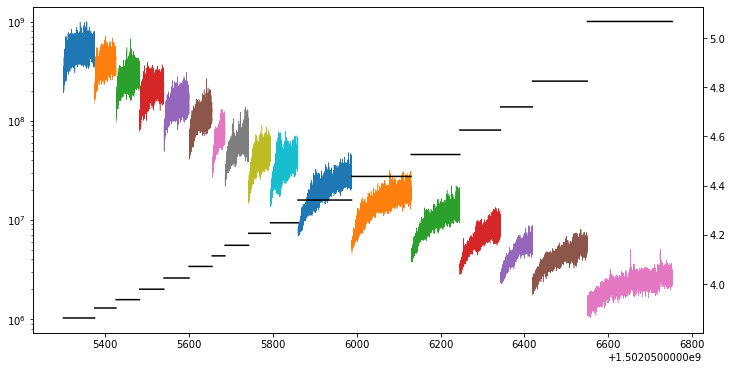

In [27]:
# plt.figure(figsize=(18, 6))
plt.figure(figsize=(12, 6))

for s in new_slices:
    plt.plot(s[0], s[1] / fixed_value, linewidth=0.5)
plt.yscale("log")

plt.twinx()
for s in new_slices:
    plt.plot(
        s[0],
        np.ones_like(s[0]) * s[2],
        c="black")

# Interpolations

In [28]:
def gather_points(slices, end_sample):
    points = []
    for s in slices:
        points.append((
            s[0][-1],
            np.nanmin(s[1][-end_sample:]),
            np.nanmean(s[1][-end_sample:]),
            np.nanmax(s[1][-end_sample:]),
        ))
    return points

In [29]:
import scipy.optimize
points = gather_points(new_slices, end_sample=50)

f_basic = scipy.interpolate.interp1d(
    np.array([p[0] for p in points]),
    np.array([p[3] for p in points]),
    kind="quadratic",
    bounds_error=False,
    fill_value=np.nan
)

In [77]:
points = gather_points(new_slices, end_sample=50)

f_forfun = scipy.interpolate.interp1d(
    np.array([p[0] for p in points]),
    np.array([p[3] for p in points]),
    kind="next",
    bounds_error=False,
    fill_value=np.nan
)

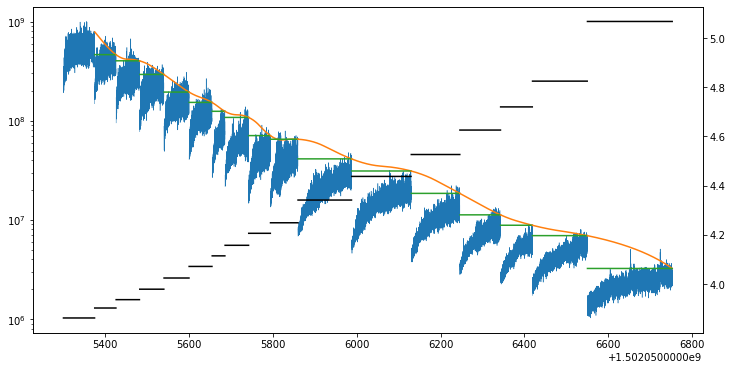

In [78]:
# plt.figure(figsize=(18, 6))
plt.figure(figsize=(12, 6))

for s in new_slices:
    plt.plot(s[0], s[1] / fixed_value, linewidth=0.5, c="C0")

    plt.plot(s[0], f_basic(s[0]) / fixed_value, c="C1")
    plt.plot(s[0], f_forfun(s[0]) / fixed_value, c="C2")
    
plt.yscale("log")

plt.twinx()
for s in new_slices:
    plt.plot(
        s[0],
        np.ones_like(s[0]) * s[2],
        c="black")

In [31]:
t = np.array([p[0] for p in points])
v = np.array([p[3] for p in points])
t0 = t[0]

In [32]:
import lmfit

In [33]:
def res(params, x, y):
    a = params["a"].value
    b = params["b"].value
    c = params["c"].value
    return ((a * np.exp(-(np.power(10.0,b)) * (x-t0)) + c) - y) / y

In [34]:
params = lmfit.Parameters()
params.add("a", value=1)
params.add("b", value=-1)
params.add("c", value=0, vary=False)

In [35]:
result = lmfit.minimize(res, params, args=(t, v))

In [36]:
result

In [37]:
def fitted_function(x):
    a = result.params["a"].value
    b = result.params["b"].value
    c = result.params["c"].value
    return a * np.exp(-(np.power(10.0,b)) * (x-t0)) + c

In [38]:
f_spline = scipy.interpolate.UnivariateSpline(
    t, np.log10(v), k=3, s=1
)

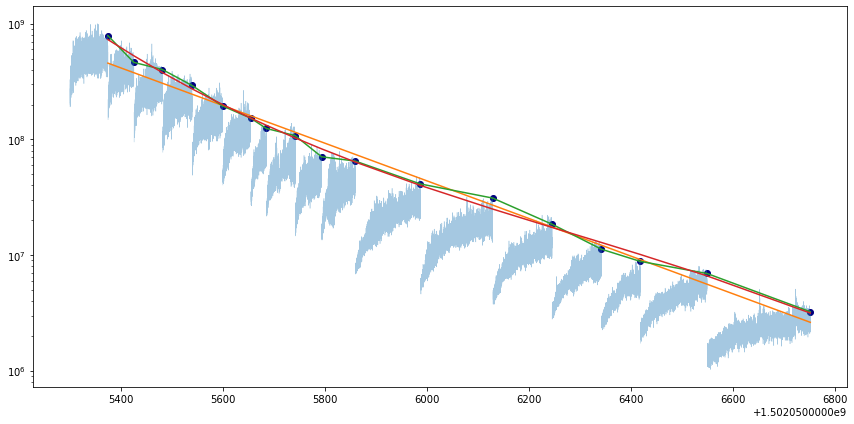

In [39]:
plt.figure(figsize=(12, 6))

for s in new_slices:
    plt.plot(s[0], s[1] / fixed_value, linewidth=0.5, c="C0", alpha=0.4)
    
plt.scatter(t, v / fixed_value, c="navy")

plt.plot(t, fitted_function(t) / fixed_value, c="C1")
plt.plot(t, f_basic(t) / fixed_value, c="C2")
plt.plot(t, np.power(10.0, f_spline(t)) / fixed_value, c="C3")

plt.yscale("log")

plt.tight_layout()

In [40]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [41]:
slice = 30
skipping = 300

In [42]:
fit_x_raw = []
fit_x_nonorm = []
fit_y_raw = []
fit_x_list = []
fit_y_list = []

for i in range(1, len(new_slices)):
    from_value = new_slices[i-1][2]
    to_value = new_slices[i][2]
    times = new_slices[i][0] - new_slices[i][0][0]
    the_function = fitted_function(new_slices[i][0])
    values = new_slices[i][1] / the_function

    avg_times = moving_average(times, slice)
    avg_values = moving_average(values, slice)

    avg_times = avg_times[::skipping]
    avg_values = avg_values[::skipping]
    
    tmp = moving_average(new_slices[i][0], slice)[::skipping]

    tmp = tmp[~np.isnan(avg_values)]
    avg_times = avg_times[~np.isnan(avg_values)]
    avg_values = avg_values[~np.isnan(avg_values)]
    
    fit_x_raw.append(new_slices[i][0])
    fit_y_raw.append(values)

    fit_x_nonorm.append(tmp)
    fit_x_list.append(("forward", from_value, to_value, avg_times))
    fit_y_list.append(avg_values-1)

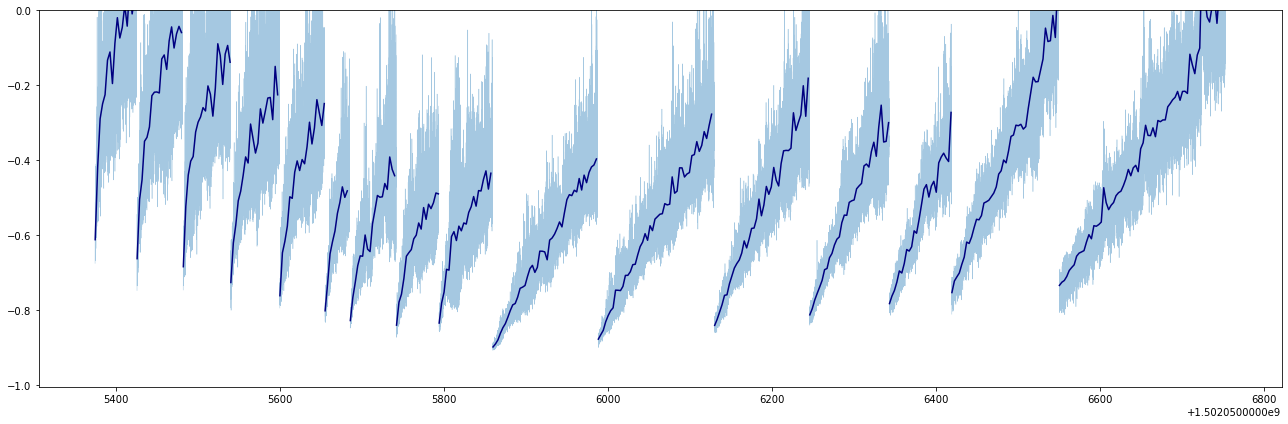

In [43]:
plt.figure(figsize=(18, 6))

for x, y in zip(fit_x_raw, fit_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(fit_x_nonorm, fit_y_list):
    plt.plot(x, y, c="navy")

plt.ylim(top=0.0)
plt.tight_layout()

In [79]:
forfun_x_raw = []
forfun_x_nonorm = []
forfun_y_raw = []
forfun_x_list = []
forfun_y_list = []

for i in range(1, len(new_slices)):
    from_value = new_slices[i-1][2]
    to_value = new_slices[i][2]
    times = new_slices[i][0] - new_slices[i][0][0]
    the_function = f_forfun(new_slices[i][0])
    values = new_slices[i][1] / the_function

    avg_times = moving_average(times, slice)
    avg_values = moving_average(values, slice)

    avg_times = avg_times[::skipping]
    avg_values = avg_values[::skipping]
    
    tmp = moving_average(new_slices[i][0], slice)[::skipping]

    tmp = tmp[~np.isnan(avg_values)]
    avg_times = avg_times[~np.isnan(avg_values)]
    avg_values = avg_values[~np.isnan(avg_values)]
    
    forfun_x_raw.append(new_slices[i][0])
    forfun_y_raw.append(values)

    forfun_x_nonorm.append(tmp)
    forfun_x_list.append(("forward", from_value, to_value, avg_times))
    forfun_y_list.append(avg_values-1)

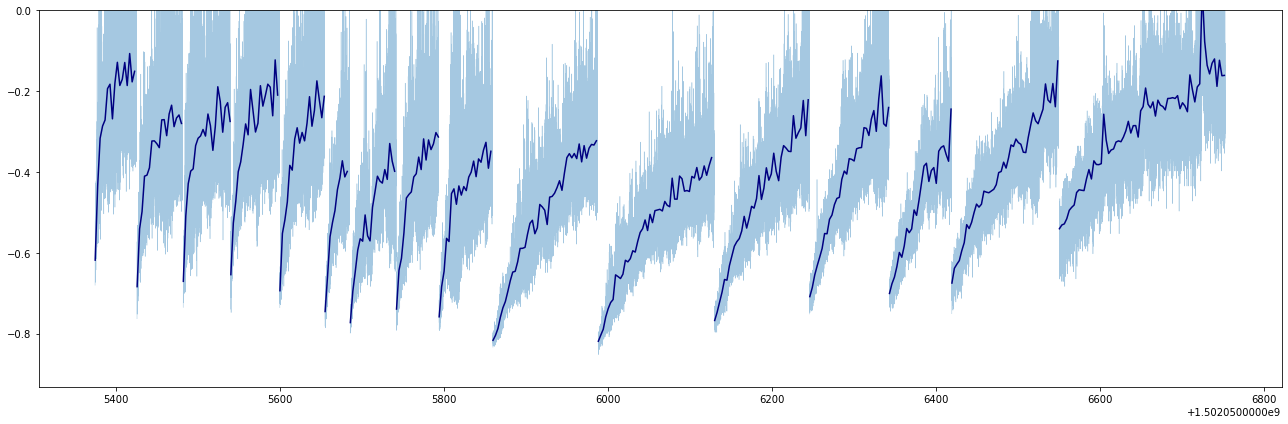

In [80]:
plt.figure(figsize=(18, 6))

for x, y in zip(forfun_x_raw, forfun_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(forfun_x_nonorm, forfun_y_list):
    plt.plot(x, y, c="navy")

plt.ylim(top=0.0)
plt.tight_layout()

In [44]:
basic_x_raw = []
basic_x_nonorm = []
basic_y_raw = []
basic_x_list = []
basic_y_list = []

for i in range(1, len(new_slices)):
    from_value = new_slices[i-1][2]
    to_value = new_slices[i][2]
    times = new_slices[i][0] - new_slices[i][0][0]
    the_function = f_basic(new_slices[i][0])
    values = new_slices[i][1] / the_function

    avg_times = moving_average(times, slice)
    avg_values = moving_average(values, slice)

    avg_times = avg_times[::skipping]
    avg_values = avg_values[::skipping]
    
    tmp = moving_average(new_slices[i][0], slice)[::skipping]

    tmp = tmp[~np.isnan(avg_values)]
    avg_times = avg_times[~np.isnan(avg_values)]
    avg_values = avg_values[~np.isnan(avg_values)]
    
    basic_x_raw.append(new_slices[i][0])
    basic_y_raw.append(values)

    basic_x_nonorm.append(tmp)
    basic_x_list.append(("forward", from_value, to_value, avg_times))
    basic_y_list.append(avg_values-1)

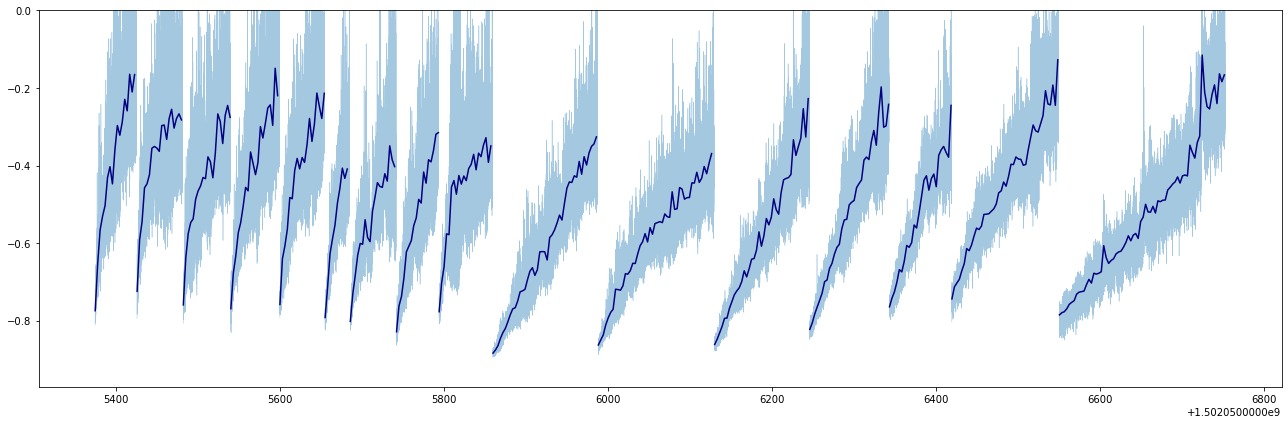

In [45]:
plt.figure(figsize=(18, 6))

for x, y in zip(basic_x_raw, basic_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(basic_x_nonorm, basic_y_list):
    plt.plot(x, y, c="navy")

plt.ylim(top=0.0)

plt.tight_layout()

In [46]:
spline_x_raw = []
spline_x_nonorm = []
spline_y_raw = []
spline_x_list = []
spline_y_list = []

for i in range(1, len(new_slices)):
    from_value = new_slices[i-1][2]
    to_value = new_slices[i][2]
    times = new_slices[i][0] - new_slices[i][0][0]
    the_function = np.power(10.0, f_spline(new_slices[i][0]))
    values = new_slices[i][1] / the_function

    avg_times = moving_average(times, slice)
    avg_values = moving_average(values, slice)

    avg_times = avg_times[::skipping]
    avg_values = avg_values[::skipping]
    
    tmp = moving_average(new_slices[i][0], slice)[::skipping]

    tmp = tmp[~np.isnan(avg_values)]
    avg_times = avg_times[~np.isnan(avg_values)]
    avg_values = avg_values[~np.isnan(avg_values)]
    
    spline_x_raw.append(new_slices[i][0])
    spline_y_raw.append(values)

    spline_x_nonorm.append(tmp)
    spline_x_list.append(("forward", from_value, to_value, avg_times))
    spline_y_list.append(avg_values-1)

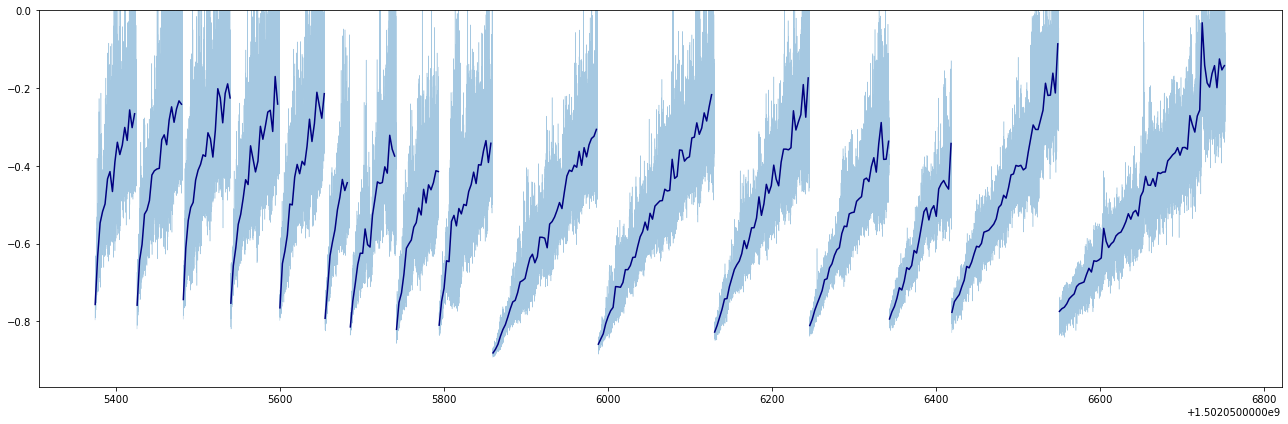

In [50]:
plt.figure(figsize=(18, 6))

for x, y in zip(spline_x_raw, spline_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(spline_x_nonorm, spline_y_list):
    plt.plot(x, y, c="navy")

plt.ylim(top=0.0)
plt.tight_layout()

In [51]:
spline_x_list

[('forward',
  3.862,
  3.9025000000000007,
  array([ 0.14500011,  3.14500011,  6.14500011,  9.14500011, 12.17500012,
         15.17500012, 18.17500012, 21.17500012, 24.17500012, 27.17500012,
         30.17500012, 33.17500012, 36.17500012, 39.17500012, 42.17500012,
         45.17500012, 48.17500012])),
 ('forward',
  3.9025000000000007,
  3.9364999999999997,
  array([ 0.14499998,  3.14499998,  6.14499998,  9.14499998, 12.14499998,
         15.14499998, 18.14499998, 21.16499998, 24.16499998, 27.16499998,
         30.16499998, 33.16499998, 36.16499998, 39.16499998, 42.16499998,
         45.16499998, 48.16499998, 51.16499998, 54.16499998])),
 ('forward',
  3.9364999999999997,
  3.979,
  array([ 0.14500003,  3.14500003,  6.14500003,  9.14500003, 12.14500003,
         15.14500003, 18.14500003, 21.14500003, 24.15100002, 27.16493335,
         30.16493335, 33.16493335, 36.16493335, 39.16493335, 42.16493335,
         45.16493335, 48.16493335, 51.16493335, 54.16493335, 57.16493335])),
 ('forward

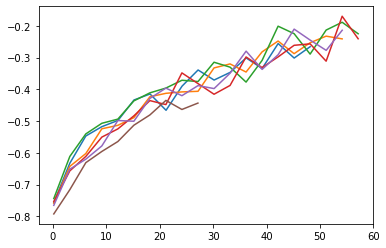

In [53]:
for i in range(0, 6):
    plt.plot(
        spline_x_list[i][3],
        spline_y_list[i],
    )

# LOAD FILES

In [54]:
with open("spline_result_c_1.0_t_single_i_spline.pkl", "rb") as f:
    spline_result = pickle.load(f)

In [56]:
spline_result["result"]

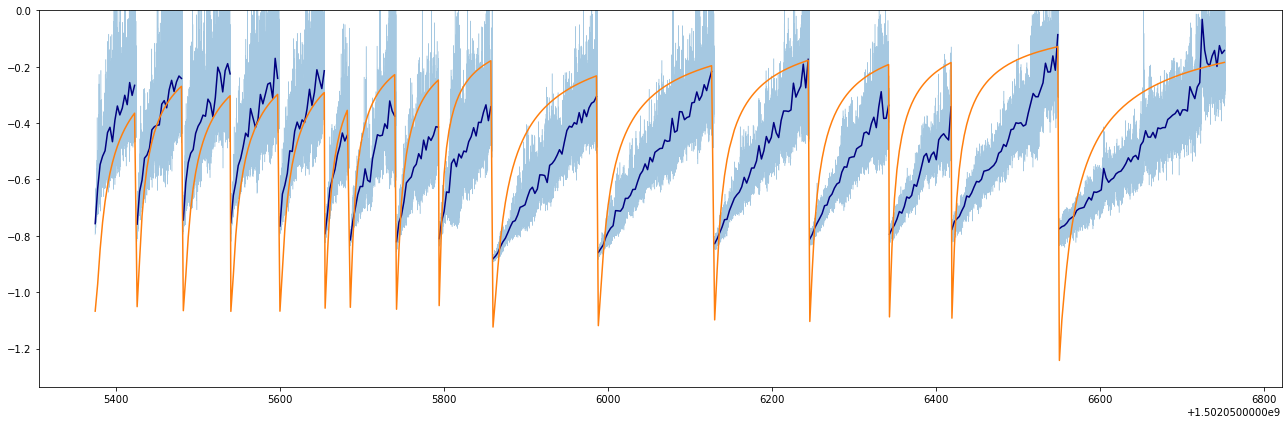

In [68]:
plt.figure(figsize=(18, 6))

tmp = np.array([])
for x in spline_x_nonorm:
    tmp = np.append(tmp, x)
for x, y in zip(spline_x_raw, spline_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(spline_x_nonorm, spline_y_list):
    plt.plot(x, y, c="navy")
plt.plot(tmp, spline_result["c2"], c="C1")
plt.ylim(top=0.0)
plt.tight_layout()

In [69]:
with open("fit_result_c_1.0_t_single_i_fit.pkl", "rb") as f:
    fit_result = pickle.load(f)

In [70]:
fit_result["result"]

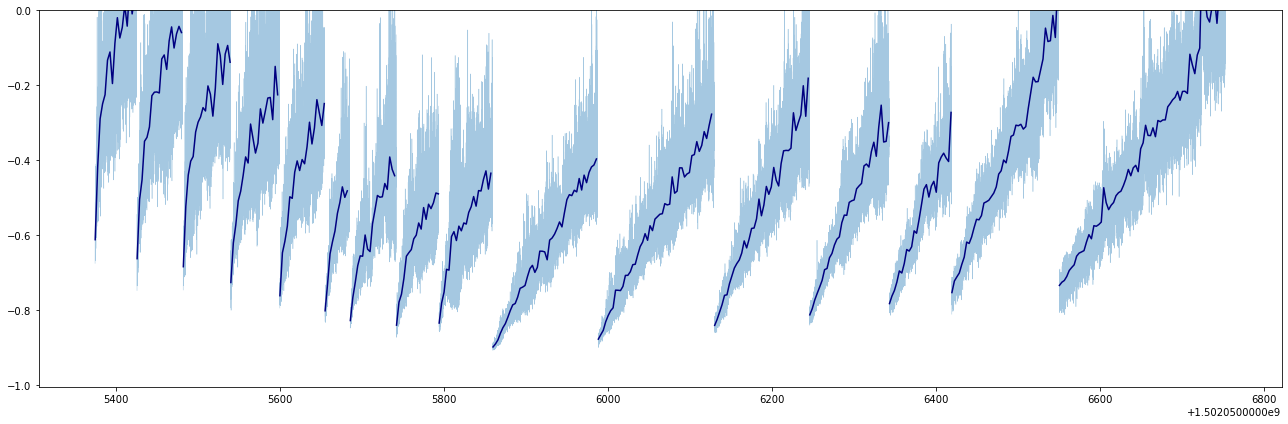

In [71]:
plt.figure(figsize=(18, 6))

for x, y in zip(fit_x_raw, fit_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(fit_x_nonorm, fit_y_list):
    plt.plot(x, y, c="navy")

plt.ylim(top=0.0)
plt.tight_layout()

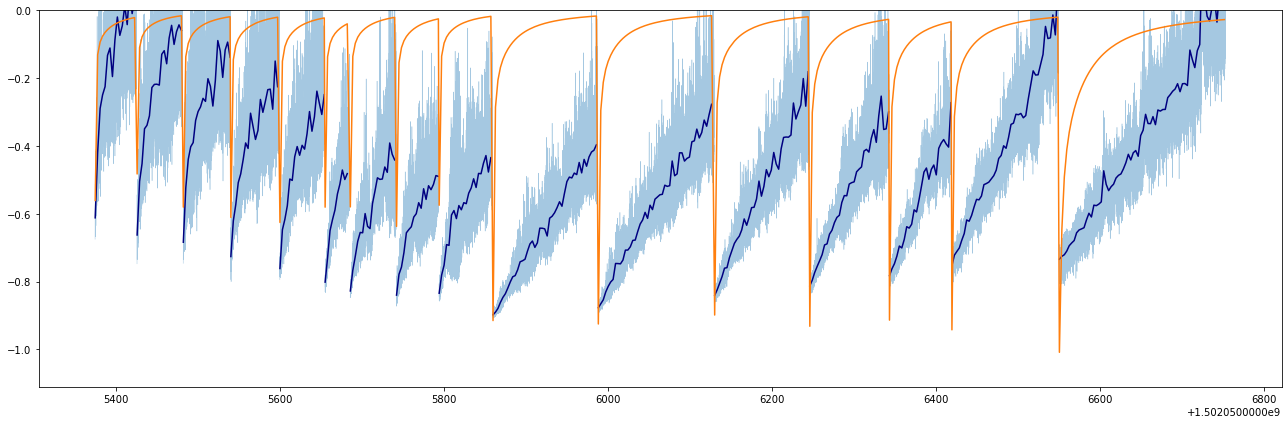

In [72]:
plt.figure(figsize=(18, 6))

tmp = np.array([])
for x in fit_x_nonorm:
    tmp = np.append(tmp, x)
for x, y in zip(fit_x_raw, fit_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(fit_x_nonorm, fit_y_list):
    plt.plot(x, y, c="navy")
plt.plot(tmp, fit_result["c2"], c="C1")
plt.ylim(top=0.0)
plt.tight_layout()

In [73]:
with open("basic_result_c_1.0_t_single_i_basic.pkl", "rb") as f:
    basic_result = pickle.load(f)

In [74]:
basic_result["result"]

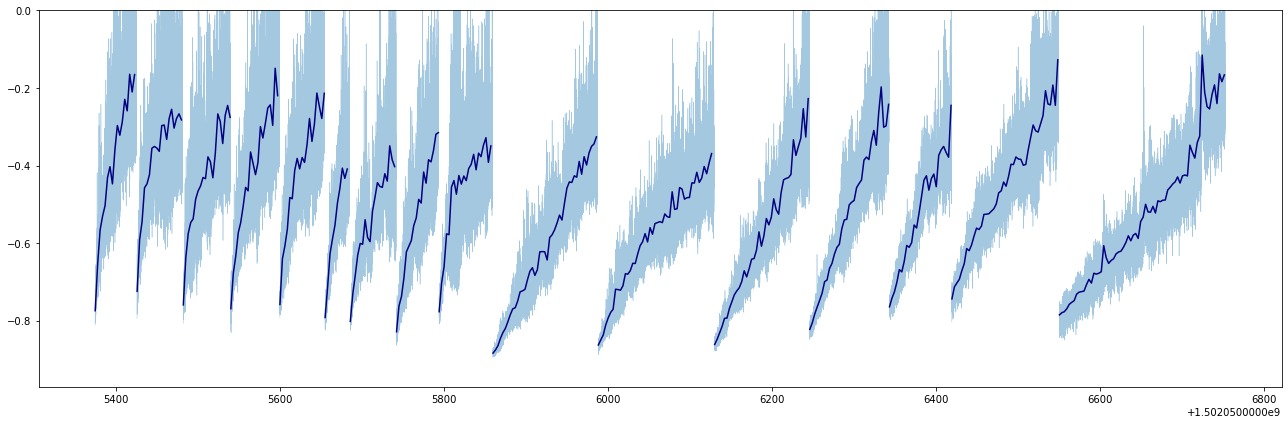

In [75]:
plt.figure(figsize=(18, 6))

for x, y in zip(basic_x_raw, basic_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(basic_x_nonorm, basic_y_list):
    plt.plot(x, y, c="navy")

plt.ylim(top=0.0)
plt.tight_layout()

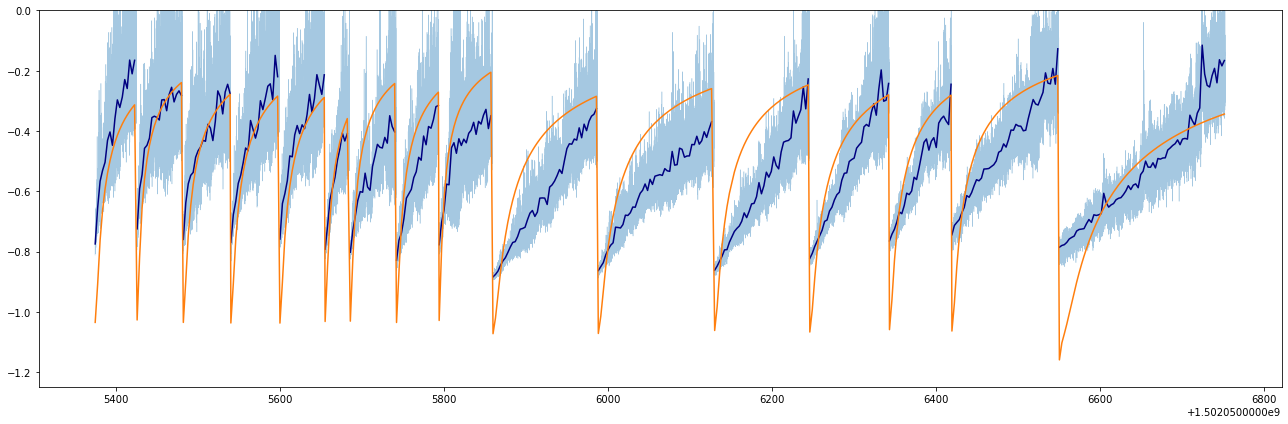

In [76]:
plt.figure(figsize=(18, 6))

tmp = np.array([])
for x in basic_x_nonorm:
    tmp = np.append(tmp, x)
for x, y in zip(basic_x_raw, basic_y_raw):
    plt.plot(x, y - 1, linewidth=0.5, c="C0", alpha=0.4)

for x, y in zip(basic_x_nonorm, basic_y_list):
    plt.plot(x, y, c="navy")
plt.plot(tmp, basic_result["c2"], c="C1")
plt.ylim(top=0.0)
plt.tight_layout()

# Individual global fits

In [ ]:
C_LIST = [0.1, 1.0, 10.0]

In [ ]:
pars = lmfit.Parameters()
pars.add("I_star", value=5.0, min=0.0)
pars.add("k", value=0.33, min=0.0)
pars.add("c", value=1.0, vary=False)

spline_result = lmfit.minimize(
    fit_functions.resid_func, pars, args=(spline_x_list, spline_y_list))
spline_c1, spline_c2 = fit_functions.ana_current(
    spline_result.params, spline_x_list, spline_y_list)

In [ ]:
with open("spline_result.pkl", "wb") as f:
    pickle.dump({
        "result": spline_result,
        "c1": spline_c1,
        "c2": spline_c2,
    }, f)

In [ ]:
pars = lmfit.Parameters()
pars.add("I_star", value=5.0, min=0.0)
pars.add("k", value=0.33, min=0.0)
pars.add("c", value=1.0, vary=False)

spline_result_list = []
for i in tqdm(range(5, len(spline_x_list))):
    spline_result = lmfit.minimize(
        fit_functions.resid_func, pars, args=(spline_x_list[:i], spline_y_list[:i]))
    spline_c1, spline_c2 = fit_functions.ana_current(
        spline_result.params, spline_x_list, spline_y_list)
    spline_result_list.append((spline_result, spline_c1, spline_c2))
    pars = spline_result.params

In [ ]:
with open("iterative_spline_result.pkl", "wb") as f:
    pickle.dump(spline_result_list, f)

In [ ]:
pars = lmfit.Parameters()
pars.add("I_star", value=5.0, min=0.0)
pars.add("k", value=0.33, min=0.0)
pars.add("c", value=1.0, vary=False)

fit_result = lmfit.minimize(
    fit_functions.resid_func, pars, args=(fit_x_list, fit_y_list))
fit_c1, fit_c2 = fit_functions.ana_current(
    fit_result.params, fit_x_list, fit_y_list)

In [ ]:
with open("fit_result.pkl", "wb") as f:
    pickle.dump({
        "result": fit_result,
        "c1": fit_c1,
        "c2": fit_c2,
    }, f)

In [ ]:
pars = lmfit.Parameters()
pars.add("I_star", value=5.0, min=0.0)
pars.add("k", value=0.33, min=0.0)
pars.add("c", value=1.0, vary=False)

fit_result_list = []
for i in tqdm(range(5, len(fit_x_list))):
    fit_result = lmfit.minimize(
        fit_functions.resid_func, pars, args=(fit_x_list[:i], fit_y_list[:i]))
    fit_c1, fit_c2 = fit_functions.ana_current(
        fit_result.params, fit_x_list, fit_y_list)
    fit_result_list.append((fit_result, fit_c1, fit_c2))
    pars = fit_result.params

In [ ]:
with open("iterative_fit_result.pkl", "wb") as f:
    pickle.dump(fit_result_list, f)

In [ ]:
pars = lmfit.Parameters()
pars.add("I_star", value=5.0, min=0.0)
pars.add("k", value=0.33, min=0.0)
pars.add("c", value=1.0, vary=False)

basic_result = lmfit.minimize(
    fit_functions.resid_func, pars, args=(basic_x_list, basic_y_list))
basic_c1, basic_c2 = fit_functions.ana_current(
    basic_result.params, basic_x_list, basic_y_list)

In [ ]:
with open("basic_result.pkl", "wb") as f:
    pickle.dump({
        "result": basic_result,
        "c1": basic_c1,
        "c2": basic_c2,
    }, f)

In [ ]:
pars = lmfit.Parameters()
pars.add("I_star", value=5.0, min=0.0)
pars.add("k", value=0.33, min=0.0)
pars.add("c", value=1.0, vary=False)

basic_result_list = []
for i in tqdm(range(5, len(basic_x_list))):
    basic_result = lmfit.minimize(
        fit_functions.resid_func, pars, args=(basic_x_list[:i], basic_y_list[:i]))
    basic_c1, basic_c2 = fit_functions.ana_current(
        basic_result.params, basic_x_list, basic_y_list)
    basic_result_list.append((basic_result, basic_c1, basic_c2))
    pars = basic_result.params

In [ ]:
with open("iterative_basic_result.pkl", "wb") as f:
    pickle.dump(basic_result_list, f)